In [15]:
import os, platform, sys, h5py
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, FloatSlider, Checkbox, FloatRangeSlider

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal
from mpltools import color

%matplotlib inline
%config InlineBackend.figure_format='retina'

When the input and output coupling capacitances are the same, the coupling quality factor is given by 

$$Q_L = \frac{\omega_0 R^* C}{2}$$

where 

$$R^* = \frac{1 + \omega_0^2 C_\kappa^2 R_L^2}{\omega_0^2 C_\kappa^2 R_L} $$

where $R_L = 50 \Omega$ and $C_\kappa$ is the coupling capacitor value. This theory comes from the paper Coplanar waveguide resonators for circuit quantum electrodynamics, M. Goppl et al., J. Appl. Phys. (2005)

In [48]:
# Feedline capacitance in F/m and inductance in nH/m
Cf_l = 126E-12 #F/m
Lf_l = 339E-9 #H/m
print("We predict the impedance of the feedline at %.2f ohms"%(np.sqrt(Lf_l/Cf_l)))

# Coupler-resonator pin cross capacitance in F/m
Ck_l = 24.2E-12 

# Insert the capacitance and inductance matrix for the resonator here: 
Cl = np.array([[151, -59.7],[-59.7, 151]]) * 1E-12
Ll = np.array([[487, 177],[177, 487]]) * 1E-9

def get_f0_from_l(l):
    L_eff = (Ll[0,0] - Ll[1,0]) * l
    C_eff = (np.abs(Cl[0,0]) + np.abs(Cl[1,0])) * l

    return 1/np.sqrt(L_eff * C_eff) * 1/4.

print("We predict the resonance at %.2f GHz"%(get_f0_from_l(4500E-6)/1E9))

Z_odd = np.sqrt((Ll[0,0]-Ll[0,1])/(np.abs(Cl[0,0]) + np.abs(Cl[1,0])))
Z_even = np.sqrt((Ll[0,0]+Ll[0,1])/(np.abs(Cl[0,0] - np.abs(Cl[1,0]))))

print("The following mode impedances have been found")
print("* Common mode : %.2f ohms" % (Z_even))
print("* Differential mode : %.2f ohms" % (Z_odd * 2))

We predict the impedance of the feedline at 51.87 ohms
We predict the resonance at 6.87 GHz
The following mode impedances have been found
* Common mode : 85.28 ohms
* Differential mode : 76.71 ohms


/Users/gkoolstra/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


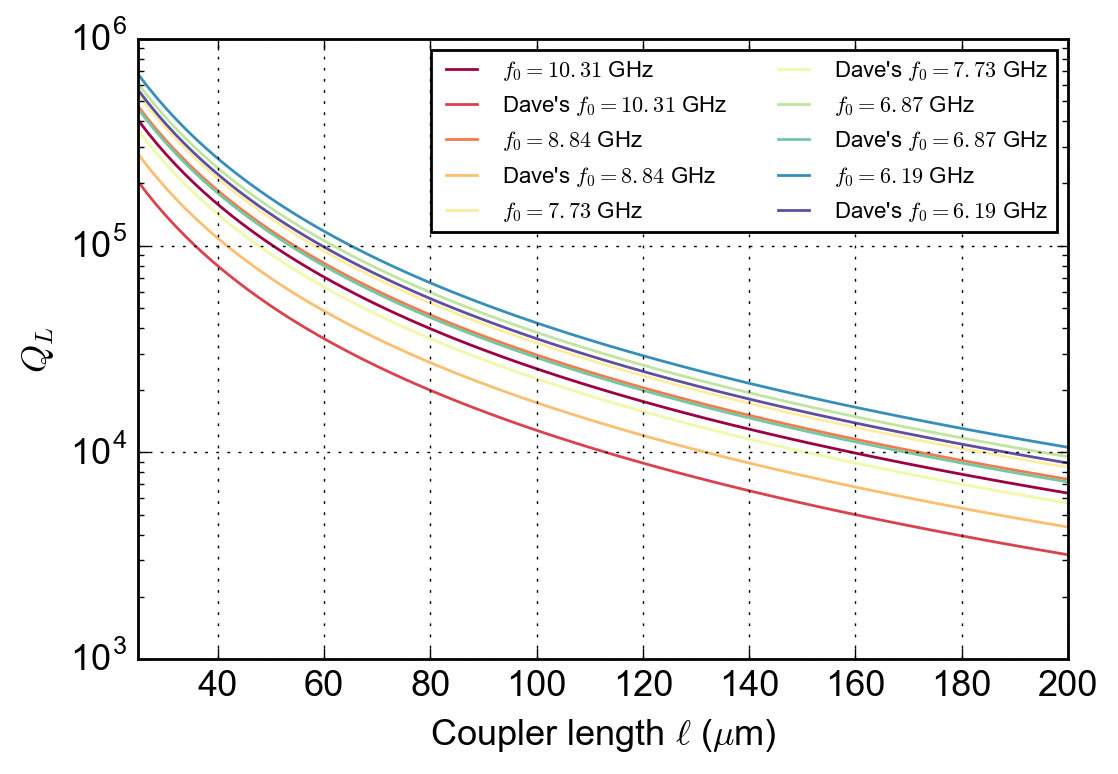

In [59]:
fig = plt.figure()
common.configure_axes(13)
color.cycle_cmap(2*5, cmap=plt.cm.Spectral)

for l in [3000E-6, 3500E-6, 4000E-6, 4500E-6, 5000E-6]:
    f0_predict = get_f0_from_l(l)
    w0 = 2 * np.pi * f0_predict
    C = C_eff
    RL = 50.
    coupler_length = np.linspace(25E-6, 200E-6, 101)
    Ck = Ck_l * coupler_length 
    Rstar = ( 1 + w0**2 * Ck**2 * RL**2 ) / (w0**2 * Ck**2 * RL)
    QL = w0 * C * Rstar / 2.
    
    qin = w0*RL*Ck
    QL_dave = np.pi/2. * 1/(2*qin**2)

    plt.plot(coupler_length * 1E6, QL, label=r"$f_0 = %.2f$ GHz"%(get_f0_from_l(l)/1E9))
    plt.plot(coupler_length * 1E6, QL_dave, label=r"Dave's $f_0 = %.2f$ GHz"%(get_f0_from_l(l)/1E9))
    plt.xlabel("Coupler length $\ell$ ($\mu$m)")
    plt.ylabel("$Q_L$")
    plt.yscale('log')
    plt.grid()
    
    #print(QL_dave/QL)
    #plt.ylim(1E3, 2E5)

plt.xlim(np.min(coupler_length*1E6), np.max(coupler_length*1E6))
plt.legend(loc=0, ncol=2, prop={"size": 8})
    
#common.save_figure(fig, save_path="/Users/gkoolstra/Documents/Code/iPythonNotebooks/Figures")

In [51]:
qin = 2*np.pi*6E9*50*4E-15
Qc = np.pi/4. * 1/(qin**2)

13815.533254504804